In [27]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

from datetime import timedelta

mapproj = cartopy.crs.PlateCarree()
xn,xx,yn,yx = [-10,4,35,44.5]

adm1 = gpd.read_file("sf_adm1/").to_crs(mapproj).clip(main_polygon(regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Spain"]].set_crs(mapproj))).set_index("id")
rnames = {"ESAN" : "Andalucia", "ESEX" : "Extremadura", "ESCM" : "Castilla la Mancha", "ESMD" : "Comunidad de Madrid", "ESMC" : "Murcia"}

ds_names = ["era5", "mswx", "eobs"]

warnings.filterwarnings("ignore", category = FutureWarning)

- Get time series & compare seasonal cycles & accumulations: Malaga; Madrid & Castilla la Mancha; Extremadura (maybe also southern Portugal?)

Maybe Murcia - there was flooding reported but it may be climatologically quite different

# Compile observational data

In [11]:
# 0.01-deg resolution (but has missing data)
# ! wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.1deg_reg_ensemble/rr_ens_mean_0.1deg_reg_v31.0e.nc -O /rds/general/user/cb2714/home/99_ephemera/eobs_rr.nc
# ! wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/months/ens/rr_0.1deg_day_2025_grid_ensmean.nc -O /rds/general/user/cb2714/home/99_ephemera/eobs_rr_2025.nc

In [46]:
# 0.25-deg resolution (but has missing data)
! wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.25deg_reg_ensemble/rr_ens_mean_0.25deg_reg_v31.0e.nc -O /rds/general/user/cb2714/home/99_ephemera/eobs_rr.nc
! wget https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/months/ens/rr_0.25deg_day_2025_grid_ensmean.nc  -O /rds/general/user/cb2714/home/99_ephemera/eobs_rr_2025.nc
clear_output(wait = False)

In [2]:
eobs_hist = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/eobs_rr.nc")).rr.sel(longitude = slice(xn,xx), latitude = slice(yn,yx))
eobs_2025 = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/eobs_rr_2025.nc")).rr.sel(longitude = slice(xn,xx), latitude = slice(yn,yx)).dropna("time", "all")

eobs = xr.concat([eobs_hist, eobs_2025], "time")
eobs = eobs.rename("pr", longitude = "lon", latitude = "lat")

eobs.to_netcdf("data/ip_eobs-gridded.nc")

In [24]:
! wget https://climexp.knmi.nl/data/era5_tp_daily_eu_extended_-10-4E_35-44.5N_-999-lastyear_su.nc -O /rds/general/user/cb2714/home/99_ephemera/era5_tp_daily_eu_extended_-10-4E_35-44.5N.nc
clear_output(wait = False)

In [25]:
era5 = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/99_ephemera/era5_tp_daily_eu_extended_-10-4E_35-44.5N.nc")).tp.rename("pr")

rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(era5)
era5 = era5.where(rm == 0)

era5.to_netcdf("data/ip_era5-gridded.nc")

In [2]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/mswx/"
for y in range(1979,2026):
    
    if y < 2025 and os.path.exists(outpath+"mswx_"+str(y)+".nc"): continue
    print(y)
    
    ds = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/P/"+str(y)+"/*")).sel(lon = slice(xn,xx), lat = slice(yn,yx)).precipitation.rename("pr").load()
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds)

    ds = ds.where(rm == 0)
    ds.to_netcdf(outpath+"mswx_"+str(y)+".nc")
clear_output(wait = False)
print("Done.")

ds = xr.open_mfdataset(outpath+"mswx_*.nc")
ds.to_netcdf("data/ip_mswx-gridded.nc")

In [ ]:
ds = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/chirps_05/*.nc")).precip
ds = ds.rename("pr", longitude = "lon", latitude = "lat").sel(lon = slice(xn,xx), lat = slice(yn,yx))
ds.to_netcdf("data/ip_chirps-gridded.nc")

## Stations

In [63]:
for stn in ["madrid-cuatrovientos", "madrid-retiro", "malaga-airport", "sevilla-sanpablo", "valencia"]:
    
    # store with date in same format as processed netcdf time series
    df = pd.read_table("data/ghcnd_"+stn+".txt", comment = "#", header = None, sep = " +", engine = "python", names = ["year", "month", "day", "pr"])
    df["time"] = pd.to_datetime(dict(year = df.year, month = df.month, day = df.day))
    df = df.set_index("time")[["pr"]]
    df = df.reindex(pd.date_range(df.index.min(), df.index.max()), fill_value = np.nan) # add missing values back in
    df.index.name = "time"
    df.to_csv("data/ghcnd_"+stn+".csv")

In [53]:
df.reindex(pd.date_range(df.index.min(), df.index.max())) # add missing values back in

In [30]:
ghcnd = pd.concat([pd.read_csv("data/ghcnd-"+c+"_2024-2025.csv", index_col = "DATE", parse_dates = ["DATE"]) for c in ["spain", "portugal"]])
ghcnd = ghcnd.loc[(ghcnd.LATITUDE >= 35) & (ghcnd.LONGITUDE >= -10)]

# ghcnd.loc[slice("2025-01",None)].to_csv("data/ghcnd-allstations_2025.csv")

<AxesSubplot: xlabel='DATE'>

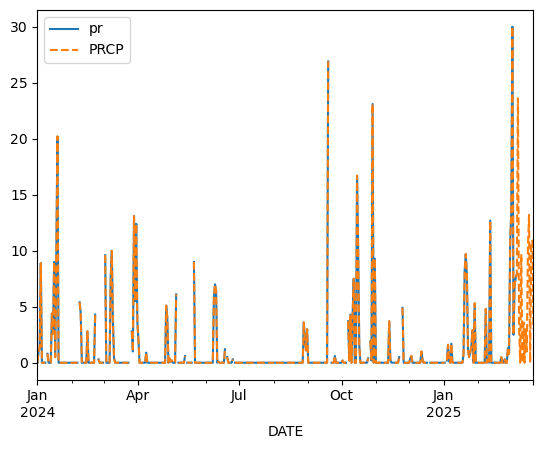

In [80]:
cx_stn.loc[slice("2024",None), ].plot()
madrid.plot(ax = plt.gca(), ls = "--")

In [73]:
cx_stncx_stn.reindex(pd.date_range(cx_stn.index.min(), cx_stn.index.max()))

<AxesSubplot: >

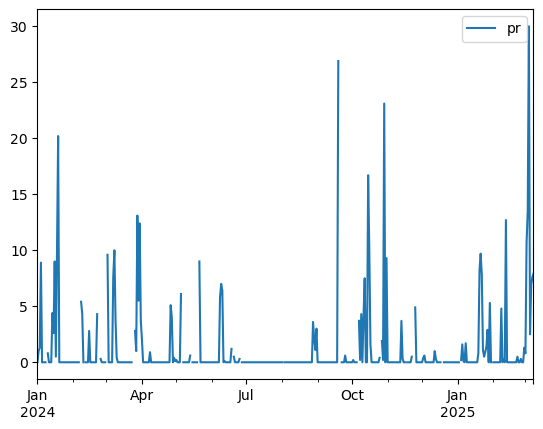

In [78]:
cx_stn.loc[slice("2024",None)].plot()

In [62]:
idx = pd.date_range('09-01-2013', '09-30-2013')

s = pd.Series({'09-02-2013': 2,
               '09-03-2013': 10,
               '09-06-2013': 5,
               '09-07-2013': 1})
s.index = pd.DatetimeIndex(s.index)

s = s.reindex(idx, fill_value=0)

# Shapefiles

In [8]:
spain = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Spain"]]
spain = main_polygon(spain)

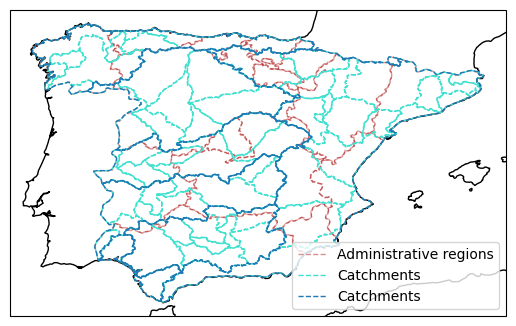

In [27]:
hybas04 = gpd.read_file("sf_hybas04").to_crs(mapproj).clip(spain.set_crs(mapproj))
hybas05 = gpd.read_file("sf_hybas05").to_crs(mapproj).clip(spain.set_crs(mapproj))
hybas06 = gpd.read_file("sf_hybas06").to_crs(mapproj).clip(spain.set_crs(mapproj))

fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

adm1.boundary.plot(ax = ax, color = "firebrick", ls = "--", lw = 1, alpha = 0.5, label = "Administrative regions")
ax.coastlines(lw = 1)
hybas06.boundary.plot(ax = ax, ls = "--", lw = 1, color = "turquoise", label = "Catchments")
hybas04.boundary.plot(ax = ax, ls = "--", lw = 1, label = "Catchments")

ax.legend(loc = "lower right")

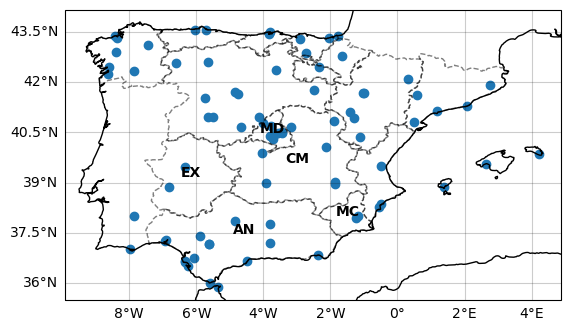

In [5]:
ghcnd = pd.read_csv("data/ghcnd-allstations_2025.csv")

fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})

adm1.boundary.plot(ax = ax, color = "k", ls = "--", lw = 1, alpha = 0.5, label = "Administrative regions")
ax.coastlines(lw = 1)

for rnm in ["AN", "EX", "CM", "MD", "MC"]:
    r = adm1.loc["ES"+rnm]
    ax.annotate(text = rnm, xy = (r.geometry.centroid.x, r.geometry.centroid.y), ha = "center", fontweight = "bold")

ax.scatter(ghcnd.LONGITUDE, ghcnd.LATITUDE)
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom", "left"])

# Physical geography & climatology

In [6]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False)).squeeze(drop = True).data.sel(lon = slice(xn,xx), lat = slice(yn,yx))

# load Koppen-Geiger classificatins, group into broader categories
kg = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(xn,xx), lat = slice(yn,yx))
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

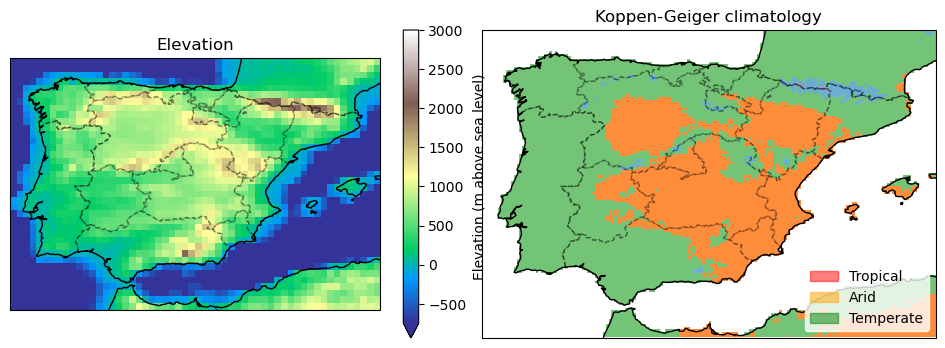

In [9]:
nr = 1; nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (6*nc, 4*nr), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.01)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
elev.plot(ax = ax, cmap = "terrain", vmin = -750, vmax = 3000, cbar_kwargs = {"label" : "Elevation (m above sea level)"})
ax.set_title("Elevation")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
#                       matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
#                       matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)
                     ], 
           edgecolor = "w", loc = "lower right")
ax.set_title("Koppen-Geiger climatology")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
#     ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    adm1.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.3, lw = 1)

plt.savefig("fig/physical-geography.png")

# Event maps

## Daily maps

In [28]:
ds_nm = "era5"

ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.sel(time = "2025-03")

In [29]:
ds

<xarray.DataArray 'pr' (time: 31, lat: 39, lon: 57)>
[68913 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2025-03-01 2025-03-02 ... 2025-03-31
  * lon      (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 3.0 3.25 3.5 3.75 4.0
  * lat      (lat) float32 35.0 35.25 35.5 35.75 36.0 ... 43.75 44.0 44.25 44.5
Attributes:
    long_name:  Precipitation
    units:      mm/day

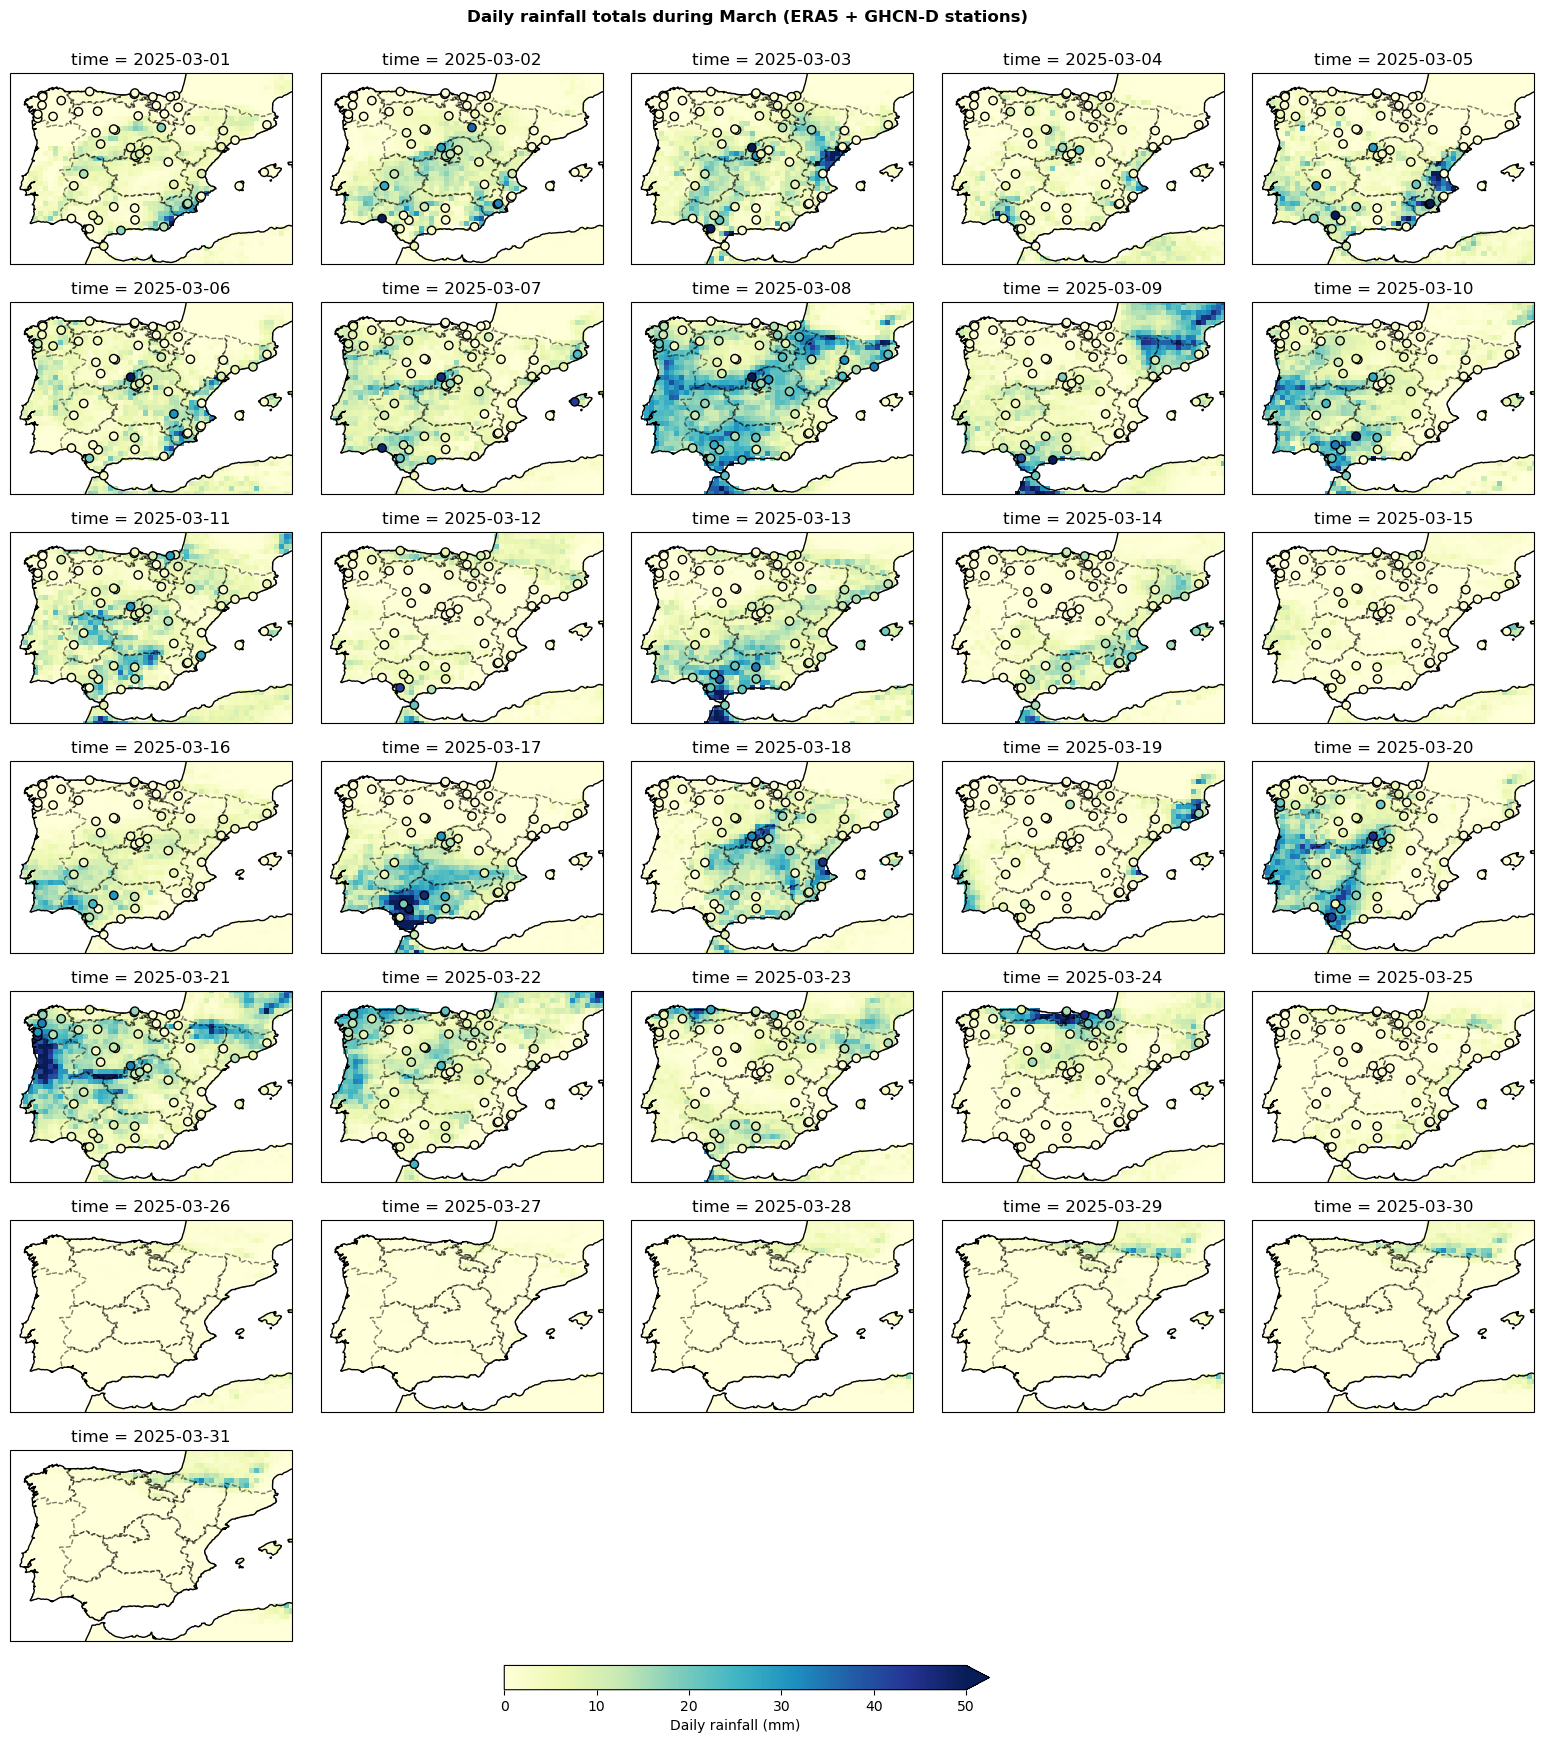

In [26]:
ghcnd = pd.read_csv("data/ghcnd-spain_2024-2025.csv", index_col = "DATE", parse_dates = ["DATE"]).dropna(axis = 0, how = "any")

nd = len(ds.time)
nc = 5
nr = int(np.ceil(nd / nc))

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 50}
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, dpi = 100)
plt.subplots_adjust(wspace = 0.01)

for i in range(nd):
    ax = axs.flatten()[i]
    da = ds.isel(time = i)

    cbar = da.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.coastlines()
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    
    d_adj = datetime(2025,3,i+1) + timedelta(days=1) # offset station dates by 1 to adjust for timing of overnight rainfall
    if d_adj in ghcnd.index:
        stn = ghcnd.loc[[d_adj]]
        ax.scatter(stn.LONGITUDE, stn.LATITUDE, c = stn.PRCP, edgecolor = "k", **plot_kwargs, zorder = 99)
    
for i in range(nd, len(axs.flatten())): axs.flatten()[i].set_axis_off()
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.015, pad = 0.015, extend = "max", label = "Daily rainfall (mm)")

plt.suptitle("Daily rainfall totals during March ("+ds_nm.upper()+" + GHCN-D stations)", fontweight = "bold", y = 0.91)
plt.savefig("fig/dailymaps_2025-03_"+ds_nm+"+ghcnd.png")

## Defined events

In [101]:
px = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Constantina, ES", "Anora", "Pujerra"]}).transpose()   # cities where fatalities were recorded
px_c1 = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Madrid", "Seville", "Valencia"]}).transpose()
px_c2 = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Malaga"]}).transpose()

px_c = pd.concat([px_c1, px_c2])

In [102]:
ds_w = ds.sel(time = slice("2025-03-17", "2025-03-22")).mean("time")
ds_m = ds.sel(time = "2025-03").mean("time")

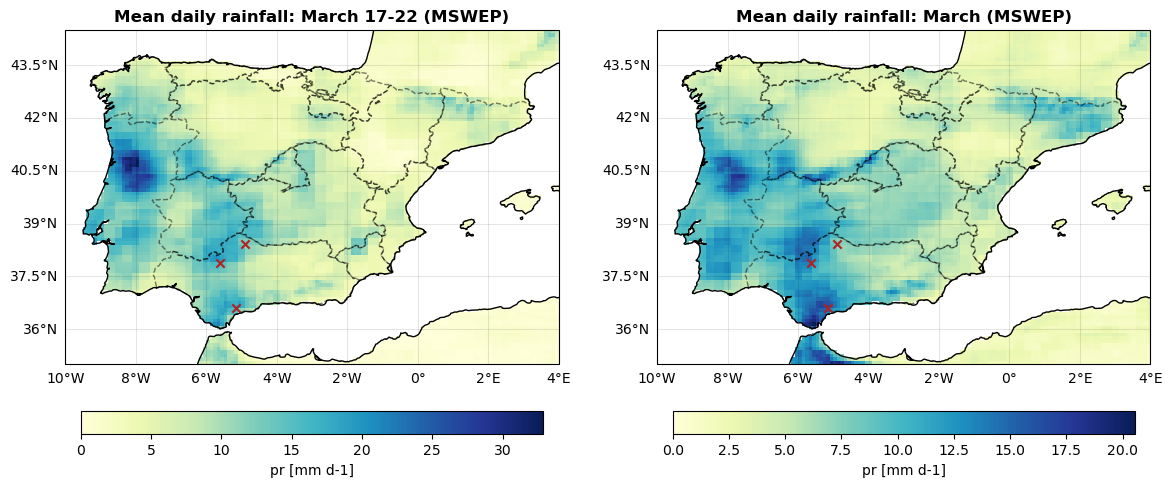

In [104]:
fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : mapproj}, figsize = (14,6))

for i in range(2):
    ax = axs[i]
    ds_i = [ds_w, ds_m][i]
    ttl = ["March 17-22", "March"][i]
    
    ds_i.plot(ax = ax, cmap = "YlGnBu", cbar_kwargs = {"location" : "bottom", "shrink" : 0.95, "fraction" : 0.05, "pad" : 0.1}, vmin = 0)
    
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.coastlines()
    ax.set_title("Mean daily rainfall: "+ttl+" (MSWEP)", fontweight = "bold")
    ax.scatter(px.lon, px.lat, marker = "x", color = "firebrick")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    
#     for c in px_c.index:
#         ax.scatter(*px_c.loc[c], marker = ".", color = "k")
#         ax.annotate(text = c, xy = (px_c.loc[c].lon, px_c.loc[c].lat), ha = "left")

## March anomalies

In [5]:
# get March 2025 mean precip & climatology
mar_2025 = {ds_nm :  xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.sel(time = slice("2025-03-01", "2025-03-24")).mean("time") for ds_nm in ds_names[:2]}
mar_clim = {ds_nm :  xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.sel(time = slice("1990","2020")).groupby("time.month")[3].mean("time") for ds_nm in ds_names[:2]}

In [80]:
ghcnd = pd.read_csv("data/ghcnd-spain_2024-2025.csv", index_col = "DATE", parse_dates = ["DATE"]).dropna(axis = 0, how = "any")
ghcnd = ghcnd.loc[(ghcnd.LATITUDE >= 35) & (ghcnd.LONGITUDE >= -10)]

In [75]:
stn_2025 = ghcnd.loc["2025-03"].groupby(["NAME"]).mean()

In [ ]:
ghcnd_m = ghcnd.loc[slice("1990", "2020")].resample("MS").mean()

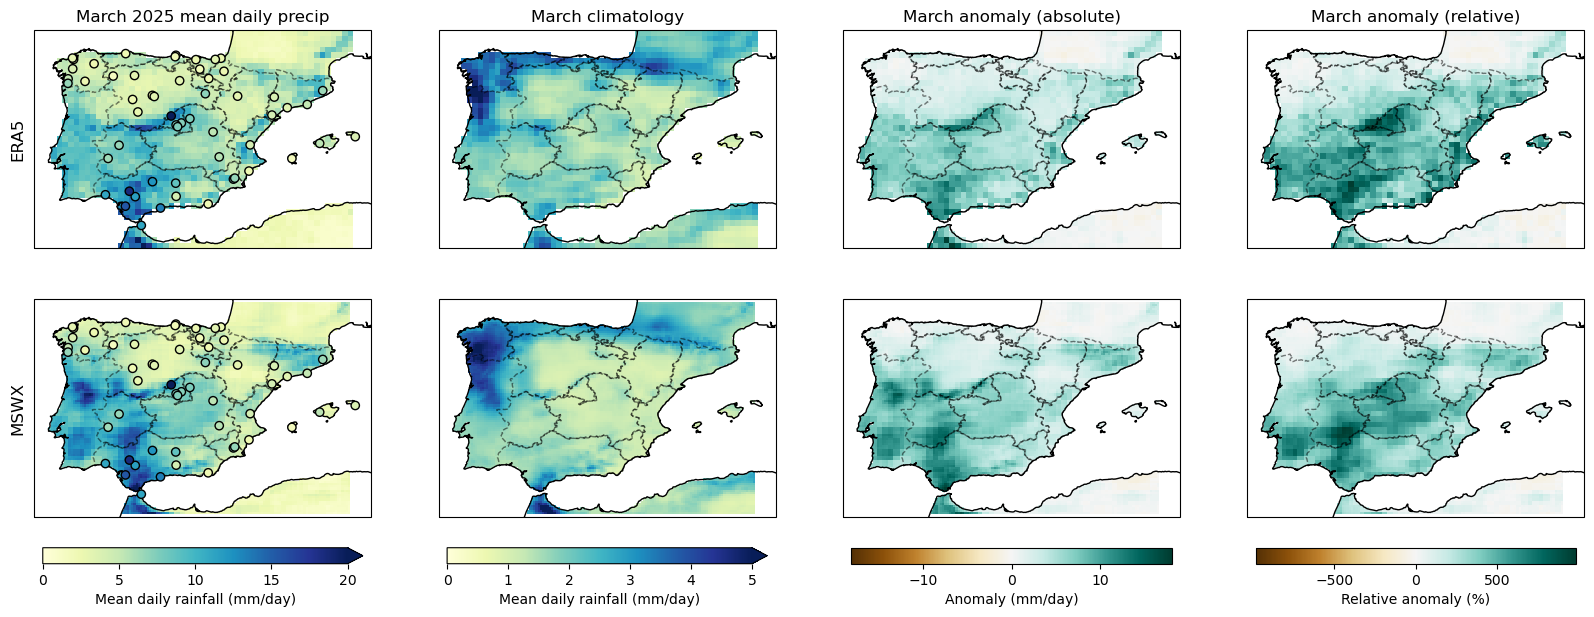

In [88]:
fig, axs = plt.subplots(ncols = 4, nrows = len(mar_clim), figsize = (5*4, 4*len(mar_clim)), subplot_kw = {"projection" : mapproj}, dpi = 100, sharex = True, sharey = True)

cbar_kwargs = {"location" : "bottom", "pad" : 0.05, "shrink" : .95}

for i in range(len(mar_clim)):
    ds_nm = list(mar_clim.keys())[i]
    
    pr_2025 = mar_2025[ds_nm]
    pr_clim = mar_clim[ds_nm]
    pr_anom = pr_2025 - pr_clim
    rel_anom = pr_anom / pr_clim * 100
    
    kwargs_2025 = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 20}
    
    cbar_2025 = pr_2025.plot(ax = axs[i,0], **kwargs_2025, add_colorbar = False)
    cbar_clim = pr_clim.plot(ax = axs[i,1], cmap = "YlGnBu", vmin = 0, vmax = 5, add_colorbar = False)
    cbar_anom = pr_anom.plot(ax = axs[i,2], cmap = "BrBG",  add_colorbar = False)
    cbar_rel = rel_anom.plot(ax = axs[i,3], cmap = "BrBG",  add_colorbar = False)
    
    axs[i,0].scatter(stn_2025.LONGITUDE, stn_2025.LATITUDE, c = stn_2025.PRCP, edgecolor = "k", **kwargs_2025, zorder = 99)
    axs[i,0].text(-0.05,0.5,ds_nm.upper(), va = "center", ha = "center", rotation='vertical', rotation_mode='anchor', transform = axs[i,0].transAxes, fontsize = "large")
    
axs[0,0].set_title("March 2025 mean daily precip")
axs[0,1].set_title("March climatology")
axs[0,2].set_title("March anomaly (absolute)")
axs[0,3].set_title("March anomaly (relative)")
    
plt.colorbar(cbar_2025, ax = axs[:,0], **cbar_kwargs, extend = "max", label = "Mean daily rainfall (mm/day)")
plt.colorbar(cbar_clim, ax = axs[:,1], **cbar_kwargs, extend = "max", label = "Mean daily rainfall (mm/day)")
plt.colorbar(cbar_anom, ax = axs[:,2], **cbar_kwargs, label = "Anomaly (mm/day)")
plt.colorbar(cbar_rel, ax = axs[:,3], **cbar_kwargs, label = "Relative anomaly (%)")

for ax in axs.flatten():
    ax.coastlines()
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    
plt.savefig("fig/March-anomalies")

# Time series

## Extract time series

In [2]:
for rnm in ["ESAN", "ESEX", "ESCM", "ESMD", "ESMC"]:
    
    adm1_r = adm1.loc[[rnm]]
    adm1_r.index = [0]
    for ds_nm in ["mswx", "chirps", "era5", "eobs"]:
        
        ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr
        rm = regionmask.mask_geopandas(adm1_r, ds.lon, ds.lat)
        ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"])
        ts.to_netcdf("data/ts-"+rnm+"_"+ds_nm+".nc")

## Daily series for GPD fitting

In [135]:
ds_nm = "era5"
for rnm in list(rnames.keys()):
    ts = xr.open_dataset("data/ts-"+rnm+"_"+ds_nm+".nc").pr
    ts.to_dataframe().to_csv("data/ts-"+rnm+"_"+ds_nm+".csv")

# 2025 vs previous years?

In [8]:
days = pd.date_range(start = "2025-01-01", end = "2026-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

ndays = [1,3,7,15,31]; nc = len(ndays)

In [ ]:
for fnm in sorted(glob.glob("data/ts-*.nc")):
    ts = xr.open_dataset(fnm).pr
    
    rcode = fnm[8:12]
    rnm = rnames[rcode]
    
    fig, axs = plt.subplots(ncols = nc, figsize = (nc*4, 2.5), dpi = 100)
    
    for i in range(nc):
        nd = ndays[i]
        ax = axs[i]
        
        ts_nday = ts.rolling(time = nd).mean()
        
        for y in range(1991,2020):
            ts_y = ts_nday.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
            
        ts_y = ts_nday.sel(time = "2025"); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2025")
        
        ax.set_title(str(nd)+"-day mean")
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
        
    plt.suptitle(rnm+" - "+fnm.split("_")[-1][:-3].upper(), y = 1.05, fontweight = "bold"); plt.close()
    plt.savefig("fig/accumulations/nday-precip_"+fnm[8:-3])

# Rx3day & Rx30day

In [79]:
for fnm in sorted(glob.glob("data/ts-*.nc")):
    ts = xr.open_dataset(fnm).pr
    
    # annual maxima
    for ndays in [3,31]:
        rxnday = ts.rolling(time = ndays).sum().resample(time = "AS-AUG").max()
        rxnday = rxnday.assign_coords(time = rxnday.time.dt.year+1).rename(time = "year").to_dataframe()
        rxnday.to_csv("ts/rx"+str(ndays)+"day_"+fnm[8:-3]+".csv")
        
    # spring maxima
    for ndays in [3,31]:
        rxnday = ts.rolling(time = ndays).sum().sel(time = ts.time.dt.month.isin([2,3,4])).resample(time = "AS-FEB").max()
        rxnday = rxnday.assign_coords(time = rxnday.time.dt.year).rename(time = "year").to_dataframe()
        rxnday.to_csv("ts/rx"+str(ndays)+"day-fma_"+fnm[8:-3]+".csv")

In [127]:
for varnm in ["rx3day", "rx31day", "rx3day-fma", "rx31day-fma"]:
    
    for rnm in list(rnames.keys()):
        nc = 4
        fig, axs = plt.subplots(ncols = nc, figsize = (nc*4, 2.5), dpi = 100, sharex = True, sharey = True)
        plt.subplots_adjust(wspace = 0.1)

        for i in range(len(ds_names)):
            
            ax = axs[i]
            ds_nm = ds_names[i]
            ts = pd.read_csv("ts/"+varnm+"_"+rnm+"_"+ds_names[i]+".csv", index_col = "year")
            ts.plot(ax = ax, drawstyle = "steps", color = "k", legend = None)
            ax.set_title(ds_nm.upper())
            ax.set_xlabel("")
            ax.set_ylabel("Accumulated rainfall (mm)")
            
            if ds_nm in ["era5", "mswx"]:
                ts.loc[[2025]].plot(ax = ax, marker = ".", ms = 10, color = "magenta", mec = "k", legend = None)
                
            ax.plot(ts.index, lowess(ts.pr.values, ts.index)[:,1], color = "dodgerblue", ls = "--", label = "Smoothed")
            xyline(ts.index, ts.pr.values, ax = ax, color = "blue", ls = "--", label = "linear fit")
                            
        plt.suptitle(varnm+" - "+rnames[rnm], fontweight = "bold", y = 1.05)
        plt.savefig("fig/"+varnm+"_"+rnm); plt.close()

# Quick gridded trends

In [128]:
gmst = pd.read_table("ts/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year").to_xarray().gmst

In [ ]:
rx3day = {}
for ds_nm in ["chirps", "era5", "mswx", "eobs"]:
    ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.rolling(time = 3).sum().resample(time = "AS-AUG").max()
    gmst_coeffs = ds.assign_coords(time = gmst.sel(year = gmst.year.isin(ds.time.dt.year)).values).polyfit("time", deg = 1).polyfit_coefficients
    rx3day[ds_nm] = gmst_coeffs.sel(degree = 1).reset_coords(drop = True)

fig, axs = plt.subplots(ncols = len(rx3day), figsize = (5 * len(rx3day), 4), subplot_kw = {"projection" : mapproj})
for i in range(len(rx3day)):
    ax = axs[i]
    ds_nm = list(rx3day.keys())[i]
    
    rx3day[ds_nm].plot(ax = ax, cmap = "BrBG", vmin = -50, vmax = 50,
                       cbar_kwargs = {"location" : "bottom", "label" : "Change per deg GMST (mm)", "shrink" : 0.9, "pad" : 0.07})
    ax.coastlines()
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.set_title(ds_nm.upper())
    
    plt.suptitle("Linear trends in rx3day", fontweight = "bold")
    plt.savefig("fig/linear-trend_rx3day")

In [ ]:
rx3day_jfm = {}
for ds_nm in ["chirps", "era5", "mswx", "eobs"]:
    ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.rolling(time = 3).sum()
    ds = ds.sel(time = ds.time.dt.month.isin([2,3,4])).resample(time = "AS-FEB").max()
    gmst_coeffs = ds.assign_coords(time = gmst.sel(year = gmst.year.isin(ds.time.dt.year)).values).polyfit("time", deg = 1).polyfit_coefficients
    rx3day_jfm[ds_nm] = gmst_coeffs.sel(degree = 1).reset_coords(drop = True)

fig, axs = plt.subplots(ncols = len(rx3day_jfm), figsize = (5 * len(rx3day_jfm), 4), subplot_kw = {"projection" : mapproj})
for i in range(len(rx3day_jfm)):
    ax = axs[i]
    ds_nm = list(rx3day_jfm.keys())[i]
    
    rx3day_jfm[ds_nm].plot(ax = ax, cmap = "BrBG", vmin = -50, vmax = 50,
                       cbar_kwargs = {"location" : "bottom", "label" : "Change per deg GMST (mm)", "shrink" : 0.9, "pad" : 0.07})
    ax.coastlines()
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.set_title(ds_nm.upper())
    
    plt.suptitle("Linear trends in rx3day (JFM)", fontweight = "bold")
    plt.savefig("fig/linear-trend_rx3dayjfm")

In [150]:
rx30day = {}
for ds_nm in ["chirps", "era5", "mswx", "eobs"]:
    ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.rolling(time = 30).sum().resample(time = "AS-AUG").max()
    gmst_coeffs = ds.assign_coords(time = gmst.sel(year = gmst.year.isin(ds.time.dt.year)).values).polyfit("time", deg = 1).polyfit_coefficients
    rx30day[ds_nm] = gmst_coeffs.sel(degree = 1).reset_coords(drop = True)

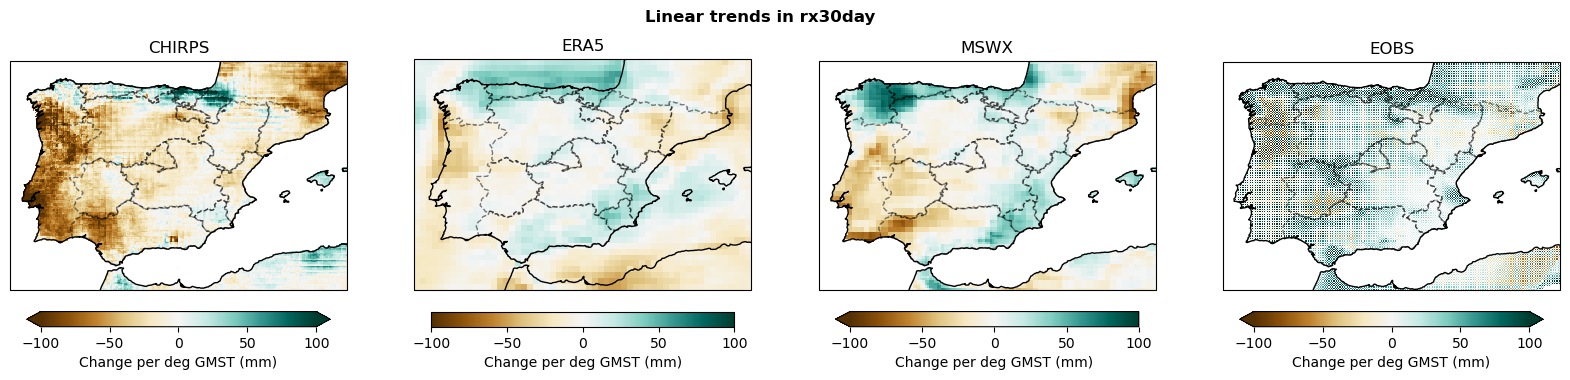

In [152]:
fig, axs = plt.subplots(ncols = len(rx30day), figsize = (5 * len(rx30day), 4), subplot_kw = {"projection" : mapproj})
for i in range(len(rx30day)):
    ax = axs[i]
    ds_nm = list(rx30day.keys())[i]
    
    rx30day[ds_nm].plot(ax = ax, cmap = "BrBG", vmin = -100, vmax = 100,
                       cbar_kwargs = {"location" : "bottom", "label" : "Change per deg GMST (mm)", "shrink" : 0.9, "pad" : 0.07})
    ax.coastlines()
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.set_title(ds_nm.upper())
    
    plt.suptitle("Linear trends in rx30day", fontweight = "bold")
    plt.savefig("fig/linear-trend_rx30day")

In [147]:
rx30day_jfm = {}
for ds_nm in ["chirps", "era5", "mswx", "eobs"]:
    ds = xr.open_dataset("data/ip_"+ds_nm+"-gridded.nc").pr.rolling(time = 30).sum()
    ds = ds.sel(time = ds.time.dt.month.isin([2,3,4])).resample(time = "AS-FEB").max()
    gmst_coeffs = ds.assign_coords(time = gmst.sel(year = gmst.year.isin(ds.time.dt.year)).values).polyfit("time", deg = 1).polyfit_coefficients
    rx30day_jfm[ds_nm] = gmst_coeffs.sel(degree = 1).reset_coords(drop = True)

fig, axs = plt.subplots(ncols = len(rx30day_jfm), figsize = (5 * len(rx30day_jfm), 4), subplot_kw = {"projection" : mapproj})
for i in range(len(rx30day_jfm)):
    ax = axs[i]
    ds_nm = list(rx30day_jfm.keys())[i]
    
    rx30day_jfm[ds_nm].plot(ax = ax, cmap = "BrBG", vmin = -50, vmax = 50,
                       cbar_kwargs = {"location" : "bottom", "label" : "Change per deg GMST (mm)", "shrink" : 0.9, "pad" : 0.07})
    ax.coastlines()
    adm1.boundary.plot(ax = ax, color = "k", alpha = 0.5, ls = "--", lw = 1)
    ax.set_title(ds_nm.upper())
    
    plt.suptitle("Linear trends in rx30day (JFM)", fontweight = "bold")
    plt.savefig("fig/linear-trend_rx30dayjfm")

In [74]:
df = pd.read_csv("data/ghcnd_valencia.csv", parse_dates = ["time"], index_col = "time")
rx3day = df.rolling(3).sum().resample("AS-AUG").max()

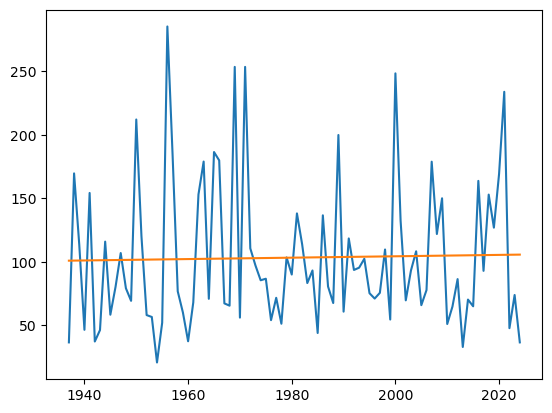

In [79]:
plt.plot(rx3day.index.year, rx3day.pr)
xyline(rx3day.index.year, rx3day.pr, ax = plt.gca())

# Larger region

In [89]:
ds = xr.open_dataset("data/ip_era5-gridded.nc").pr

In [103]:
adm1["x"] = range(len(adm1))

In [115]:
rm = regionmask.mask_geopandas(adm1.loc[["ESCM", "ESMD", "ESAN", "ESEX"]], ds.lon, ds.lat, numbers = "x")

In [116]:
ts = ds.where(np.isnan(rm), drop = True).mean(["lat", "lon"])

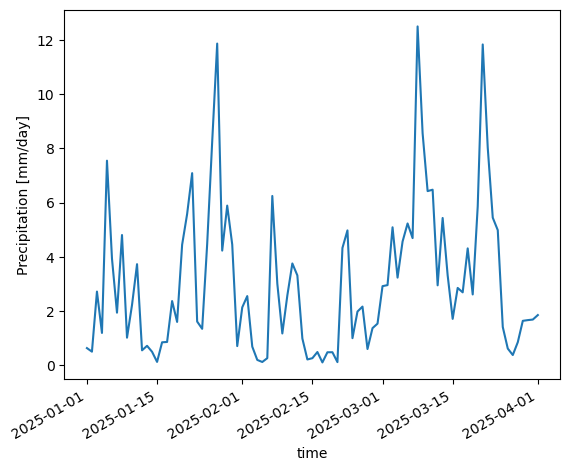

In [117]:
ts.sel(time = "2025").plot()